<a href="https://colab.research.google.com/github/google/jax-md/blob/main/notebooks/equivariant_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
#@title Import & Util

!pip install --upgrade pip
# Installs the wheel compatible with CUDA 11 and cuDNN 8.2 or newer.
# Note: wheels only available on linux.
!pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install git+https://github.com/e3nn/e3nn-jax.git
!pip install git+https://github.com/google/jax-md.git
!pip install dm-haiku
!pip install optax

import jax.numpy as np
from jax import device_put
from jax import config
# TODO: Uncomment this and enable warnings when XLA bug is fixed.
import warnings; warnings.simplefilter('ignore')
config.update('jax_enable_x64', True)
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import warnings
warnings.simplefilter("ignore")

sns.set_style(style='white')
background_color = [56 / 256] * 3
def plot(x, y, *args):
  plt.plot(x, y, *args, linewidth=3)
  plt.gca().set_facecolor([1, 1, 1])
def draw(R, **kwargs):
  if 'c' not in kwargs:
    kwargs['color'] = [1, 1, 0.9]
  ax = plt.axes(xlim=(0, float(np.max(R[:, 0]))),
                ylim=(0, float(np.max(R[:, 1]))))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax.set_facecolor(background_color)
  plt.scatter(R[:, 0], R[:, 1],  marker='o', s=1024, **kwargs)
  plt.gcf().patch.set_facecolor(background_color)
  plt.gcf().set_size_inches(6, 6)
  plt.tight_layout()
def draw_big(R, **kwargs):
  if 'c' not in kwargs:
    kwargs['color'] = [1, 1, 0.9]
  fig = plt.figure(dpi=128)
  ax = plt.axes(xlim=(0, float(np.max(R[:, 0]))),
                ylim=(0, float(np.max(R[:, 1]))))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax.set_facecolor(background_color)
  s = plt.scatter(R[:, 0], R[:, 1], marker='o', s=0.5, **kwargs)
  s.set_rasterized(True)
  plt.gcf().patch.set_facecolor(background_color)
  plt.gcf().set_size_inches(10, 10)
  plt.tight_layout()
def draw_displacement(R, dR):
  plt.quiver(R[:, 0], R[:, 1], dR[:, 0], dR[:, 1], color=[1, 0.5, 0.5])

# Progress Bars

from IPython.display import HTML, display
import time

def ProgressIter(iter_fun, iter_len=0):
  if not iter_len:
    iter_len = len(iter_fun)
  out = display(progress(0, iter_len), display_id=True)
  for i, it in enumerate(iter_fun):
    yield it
    out.update(progress(i + 1, iter_len))

def progress(value, max):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 45%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Data Loading

!wget -O silica_train.npz https://www.dropbox.com/s/3dojk4u4di774ve/silica_train.npz?dl=0
!wget https://raw.githubusercontent.com/google/jax-md/main/examples/models/si_equivariant.pickle

import numpy as onp

with open('silica_train.npz', 'rb') as f:
  files = onp.load(f)
  Rs, Es, Fs = [device_put(x) for x in (files['arr_0'], files['arr_1'], files['arr_2'])]
  test_Rs, test_Es, test_Fs = [device_put(x) for x in (files['arr_3'], files['arr_4'], files['arr_5'])]
  test_Rs = test_Rs[:200]
  test_Es = test_Es[:200]
  test_Fs = test_Fs[:200]

def tile(box_size, positions, tiles):
  pos = positions
  for dx in range(tiles):
    for dy in range(tiles):
      for dz in range(tiles):
        if dx == 0 and dy == 0 and dz == 0:
          continue
        pos = np.concatenate((pos, positions + box_size * np.array([[dx, dy, dz]])))
  box_size = box_size * tiles
  pos /= box_size
  return box_size, pos

# Equivariant Talk Demo

www.github.com/google/jax-md -> notebooks/equivariant_neural_networks.ipynb

## Dataset

Start with different phases of Silicon computed using DFT.

In [2]:
print(f'Positions: {Rs.shape}')
print(f'Energies:  {Es.shape}')
print(f'Forces:    {Fs.shape}')

Positions: (2416, 64, 3)
Energies:  (2416,)
Forces:    (2416, 64, 3)


In [3]:
BOX_SIZE = 10.862
N = 64

Instantiate a space with periodic boundary conditions

In [4]:
from jax_md import space
displacement, shift = space.periodic(BOX_SIZE)

In [5]:
displacement(Rs[0, 0], Rs[0, 1])

Array([-1.35785482, -1.35785862, -1.35755839], dtype=float64)

In [6]:
from jax import vmap
vmap(displacement)(Rs[0], Rs[1]).shape

(64, 3)

Construct a neighbor list.

In [7]:
from jax_md import partition

CUTOFF = 3.0
neighbor_fn = partition.neighbor_list(displacement, BOX_SIZE, CUTOFF, format=partition.Sparse)

In [8]:
nbrs = neighbor_fn.allocate(Rs[0])

In [9]:
nbrs.idx.shape

(2, 320)

Draw the system.

In [10]:
from jax_md.colab_tools import renderer
import jax.numpy as jnp

red = jnp.array([1.0, 0.2, 0.2])
blue = jnp.array([0.2, 0.2, 1.0])

renderer.render(BOX_SIZE,
                {
                    'atoms': renderer.Sphere(Rs[0], color=blue),
                    'nbrs': renderer.Bond('atoms', nbrs, color=red)
                })

## Model Definition

In [11]:
from functools import partial

from jax_md import energy

import haiku as hk

import jraph

from jax import nn

from e3nn_jax.haiku import FullyConnectedTensorProduct,  Linear
from e3nn_jax import spherical_harmonics
from e3nn_jax import IrrepsArray
from e3nn_jax import gate
from e3nn_jax import concatenate

Array = space.Array

INNER_CUTOFF = 2.7
SH_ALGORITHM = ('recursive', 'sparse')

def bessel(n: Array, dr: Array) -> Array:
  @partial(energy.multiplicative_isotropic_cutoff,
           r_onset=INNER_CUTOFF,
           r_cutoff=CUTOFF)
  def bessel_fn(dr: Array) -> Array:
    return 2 / CUTOFF * jnp.sin(jnp.pi * n * dr / CUTOFF) / (dr + 1e-7)
  return bessel_fn(dr)
bessel = vmap(vmap(bessel, (0, None)), (None, 0))

def featurize_edges(dR):
  sph = spherical_harmonics('0e + 1o', dR, True, algorithm=SH_ALGORITHM)
  be = bessel(jnp.arange(5), space.distance(dR))
  prod = jnp.reshape(sph.array[:, :, None] * be[:, None, :], (-1, 20))
  return IrrepsArray('5x0e + 5x1o', prod)

class GraphNetwork(hk.Module):
  def __init__(self, displacement_fn, graph_net_steps):
    super(GraphNetwork, self).__init__()
    self.displacement = displacement_fn
    self.graph_net_steps = graph_net_steps

  def __call__(self, position, neighbor, **kwargs):
    N = position.shape[0]

    # Compute the displacement between each pair of neighbors.
    d = vmap(partial(self.displacement, **kwargs))
    dR = d(position[neighbor.idx[0, :]], position[neighbor.idx[1, :]])

    mask = partition.neighbor_list_mask(neighbor)
    dR = jnp.where(mask[:, None], dR, 0)

    # Build the jraph graph and featurize the edges.
    graph = partition.to_jraph(neighbor,
                               nodes=IrrepsArray.zeros('0e', (N,)),
                               edges=featurize_edges(dR),
                               globals=IrrepsArray.zeros('0e', (1,)))

    # Define the embedding layer.
    def embed_fn(a, x):
      return FullyConnectedTensorProduct('64x0e + 32x1o')(x, a)

    # Define the internal update layer.
    def update_fn(a, *x):
      x = concatenate(x)
      y = FullyConnectedTensorProduct('64x0e + 32x0e + 32x1o')(x, a)
      y = gate(y)
      return FullyConnectedTensorProduct('64x0e + 32x1o')(y, a)

    # Define the conditioning tensors for the nodes, edges, and globals.
    node_a = IrrepsArray('0e', jnp.ones((N + 1, 1)))
    edge_a = spherical_harmonics('1o', dR, True, algorithm=SH_ALGORITHM)
    edge_r = bessel(jnp.arange(5), space.distance(dR))
    mlp = hk.Sequential([hk.Linear(32, False),
                         nn.swish,
                         hk.Linear(self.graph_net_steps, False)])
    edge_r = vmap(mlp)(edge_r)
    global_a = IrrepsArray('2x0e', jnp.ones(2,))

    # Embed the features.
    embed = jraph.GraphMapFeatures(
        embed_node_fn = partial(embed_fn, node_a),
        embed_edge_fn = partial(embed_fn, edge_a),
        embed_global_fn = partial(embed_fn, global_a)
    )
    graph = embed(graph)

    # Run the graph network for `graph_net_steps` steps.
    for i in range(self.graph_net_steps):
      gnn = jraph.GraphNetwork(
          update_node_fn=partial(update_fn, node_a),
          update_edge_fn=partial(update_fn, edge_a * edge_r[:, [i]]),
          update_global_fn=partial(update_fn, global_a),
          aggregate_edges_for_nodes_fn=jraph.segment_mean,
          aggregate_edges_for_globals_fn=jraph.segment_mean,
          aggregate_nodes_for_globals_fn=jraph.segment_mean,
      )
      graph = gnn(graph)

    # Readout the global state into a scalar.
    out = FullyConnectedTensorProduct('0e')(graph.globals, global_a)
    return N * out.array[0, 0]

In [12]:
@hk.without_apply_rng
@hk.transform
def net(position, neighbor, **kwargs):
  return GraphNetwork(displacement, graph_net_steps=2)(position, neighbor, **kwargs)

## Training

In [13]:
from jax import random

key = random.PRNGKey(0)
nbrs = neighbor_fn.allocate(Rs[0])
params = net.init(key, Rs[0], nbrs)

In [14]:
net.apply(params, Rs[0], nbrs)

Array(-0.00596532, dtype=float64)

In [15]:
from jax import jit
from jax import value_and_grad
from jax import grad

def single_loss_fn(params, position, E_target, F_target):
  l_nbrs = nbrs.update(position)
  E, G = value_and_grad(net.apply, argnums=1)(params, position, l_nbrs)
  return (E - E_target) ** 2, (G + F_target) ** 2

@jit
def loss_fn(params, position, E_target, F_target):
  F_lam = 1.0
  v_loss_fn = vmap(single_loss_fn, (None, 0, 0, 0))
  E_loss, F_loss = v_loss_fn(params, position, E_target, F_target)
  return jnp.sum(E_loss) / (N**2) + F_lam * jnp.sum(F_loss) / (3 * N)

In [16]:
import optax

BATCH_SIZE = 8
TRAINING_STEPS = 10_000

schedule = optax.cosine_decay_schedule(1e-3, TRAINING_STEPS)
opt = optax.adam(schedule)
opt_state = opt.init(params)

@jit
def update(params, opt_state, position, E_target, F_target):
  L = partial(loss_fn, position=position, E_target=E_target, F_target=F_target)
  updates, opt_state = opt.update(grad(L)(params), opt_state)
  return optax.apply_updates(params, updates), opt_state

cur = 0

for i in ProgressIter(range(TRAINING_STEPS)):
  R_batch = Rs[cur:cur+BATCH_SIZE]
  E_batch = Es[cur:cur+BATCH_SIZE]
  F_batch = Fs[cur:cur+BATCH_SIZE]
  if i % 200 == 0:
    print(f'Step: {i}, '
          f'Train Loss: {loss_fn(params, Rs[:100], Es[:100], Fs[:100])}, '
          f'Test Loss: {loss_fn(params, test_Rs, test_Es, test_Fs)}')
  params, opt_state = update(params, opt_state, R_batch, E_batch, F_batch)
  cur += BATCH_SIZE
  if cur + BATCH_SIZE > len(Rs):
    cur = 0

Step: 0, Train Loss: 3342.4450273558414, Test Loss: 6635.240024394559
Step: 200, Train Loss: 15.790216367285066, Test Loss: 30.009116925562985
Step: 400, Train Loss: 10.07984915966502, Test Loss: 19.581476815877934
Step: 600, Train Loss: 8.297217735267095, Test Loss: 16.730356792664075
Step: 800, Train Loss: 9.253985301649532, Test Loss: 17.983031153378004
Step: 1000, Train Loss: 7.487490970696001, Test Loss: 15.15396764885989
Step: 1200, Train Loss: 7.5317160791303746, Test Loss: 15.12854194804698
Step: 1400, Train Loss: 7.235043468031587, Test Loss: 14.56650615112497
Step: 1600, Train Loss: 7.431016366319691, Test Loss: 15.493453815624191
Step: 1800, Train Loss: 7.455517394870477, Test Loss: 15.536309956659085
Step: 2000, Train Loss: 7.9314859945807985, Test Loss: 16.61172621268329
Step: 2200, Train Loss: 7.619811028524394, Test Loss: 14.923004232144521
Step: 2400, Train Loss: 6.666457807118094, Test Loss: 13.41820788421137
Step: 2600, Train Loss: 6.7053403066755415, Test Loss: 13.29

In [17]:
import pickle

with open('si_equivariant.pickle', 'wb') as f:
  pickle.dump(params, f)

## Evaluating the potential.

In [18]:
import pickle

with open('si_equivariant.pickle', 'rb') as f:
  params = pickle.load(f)

In [19]:
from jax import jit

@jit
def energy_fn(position, **kwargs):
  l_nbrs = nbrs.update(position)
  return net.apply(params, position, l_nbrs, **kwargs)

pred_Es = vmap(energy_fn)(test_Rs)

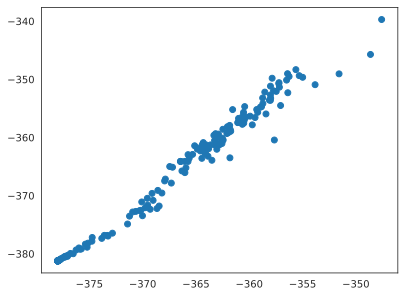

In [20]:
plt.plot(pred_Es, test_Es, 'o')

In [21]:
jnp.mean(jnp.abs(pred_Es - test_Es)) * 1000 / 64

Array(49.99966006, dtype=float64)

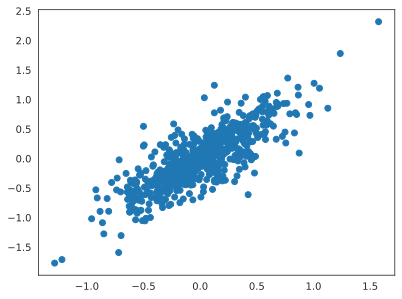

In [22]:
from jax import grad

grad_fn = grad(energy_fn)
pred_Gs = vmap(grad_fn)(test_Rs[:5])
plt.plot(-pred_Gs.reshape((-1,)), test_Fs[:5].reshape((-1,)), 'o')

In [23]:
jnp.mean(jnp.abs(-pred_Gs - test_Fs[:5])) * 1000

Array(159.75206954, dtype=float64)

## Minimization

In [24]:
from jax_md import minimize

init_fn, step_fn = minimize.fire_descent(energy_fn, shift)

In [25]:
state = init_fn(Rs[2])

positions = []

for i in ProgressIter(range(100)):
  positions += [state.position]
  state = jit(step_fn)(state)

In [26]:
positions = jnp.stack(positions)
renderer.render(BOX_SIZE, renderer.Sphere(positions))

In [27]:
from jax_md import quantity

quantity.stress(energy_fn, state.position, BOX_SIZE)

Array([[-0.04348717, -0.00885171,  0.00190437],
       [-0.00885275, -0.03773228, -0.00434214],
       [ 0.00189829, -0.00434228, -0.04419517]], dtype=float64)

In [28]:
from jax_md import elasticity

elasticity.athermal_moduli(energy_fn)(state.position, BOX_SIZE)

Array([[[[ 0.56585565, -0.05514268, -0.00514669],
         [-0.05514268,  0.558432  , -0.02721843],
         [-0.00514669, -0.02721843,  0.52863868]],

        [[-0.05514268,  0.71936548,  0.02371183],
         [ 0.71936548, -0.0449463 , -0.01151022],
         [ 0.02371183, -0.01151022, -0.06059118]],

        [[-0.00514669,  0.02371183,  0.74278641],
         [ 0.02371183, -0.00441154, -0.00390406],
         [ 0.74278641, -0.00390406, -0.00452319]]],


       [[[-0.05514268,  0.71936548,  0.02371183],
         [ 0.71936548, -0.0449463 , -0.01151022],
         [ 0.02371183, -0.01151022, -0.06059118]],

        [[ 0.558432  , -0.0449463 , -0.00441154],
         [-0.0449463 ,  0.62674673, -0.01967451],
         [-0.00441154, -0.01967451,  0.56563736]],

        [[-0.02721843, -0.01151022, -0.00390406],
         [-0.01151022, -0.01967451,  0.74584964],
         [-0.00390406,  0.74584964, -0.02050486]]],


       [[[-0.00514669,  0.02371183,  0.74278641],
         [ 0.02371183, -0.00441154

## Scaled Up NPT

In [29]:
LARGE_BOX, R = tile(BOX_SIZE, Rs[2], 3)

In [30]:
R.shape

(1728, 3)

In [31]:
displacement, shift = space.periodic_general(LARGE_BOX)

In [32]:
@jit
def energy_fn(position, neighbor, **kwargs):
  return net.apply(params, position, neighbor, **kwargs)

In [33]:
neighbor_fn = partition.neighbor_list(displacement,
                                      LARGE_BOX,
                                      r_cutoff=CUTOFF,
                                      fractional_coordinates=True,
                                      format=partition.Sparse)

In [34]:
nbrs = neighbor_fn.allocate(R)

energy_fn(R, nbrs) / R.shape[0]

Array(-5.64554691, dtype=float64)

In [35]:
# Define Physical Constants

K_B = 8.617e-5
dt = 1e-3
P_start = 0.0
kT = K_B * 300
Si_mass = 2.81086E-3

In [36]:
from jax_md import simulate
init_fn, step_fn = simulate.npt_nose_hoover(energy_fn, shift, dt, P_start, kT)

In [37]:
from jax.lax import fori_loop

@jit
def sim_fn(i, state_nbrs, pressure):
  state, nbrs = state_nbrs
  state = step_fn(state, pressure=pressure, neighbor=nbrs)
  nbrs = nbrs.update(state.position, box=state.box)
  return state, nbrs

In [38]:
@jit
def compute_diagnostics(state, nbrs):
  temperature = quantity.temperature(momentum=state.momentum, mass=Si_mass) / K_B
  kinetic_energy = quantity.kinetic_energy(momentum=state.momentum, mass=Si_mass)
  pressure = quantity.pressure(energy_fn, state.position, state.box, kinetic_energy, neighbor=nbrs)
  position = space.transform(state.box, state.position)
  return temperature, pressure, position

In [39]:
from jax import random
key = random.PRNGKey(0)
state = init_fn(key, R, LARGE_BOX, Si_mass, neighbor=nbrs)

In [40]:
total_steps = 1000
times = np.arange(0, total_steps) * dt
temperatures = []
pressures = []
trajectory = []
P_target = P_start
for t in ProgressIter(times):
  state, nbrs = sim_fn(t, (state, nbrs), P_target)
  if nbrs.did_buffer_overflow.any():
    nbrs = neighbor_fn.allocate(state.position)
  temperature, pressure, position = compute_diagnostics(state, nbrs)

  temperatures += [temperature]
  pressures += [pressure]
  trajectory += [position]

In [41]:
nbrs.did_buffer_overflow

Array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=uint8)

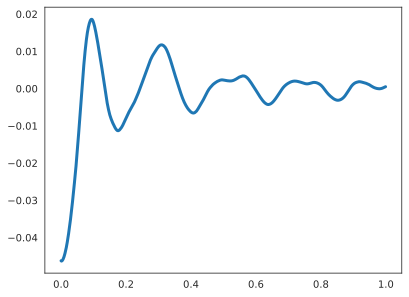

In [42]:
plot(times, pressures)

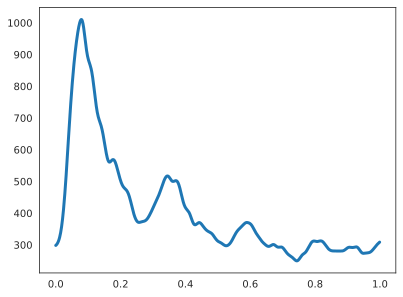

In [43]:
plot(times, temperatures)

In [44]:
from jax_md import partition
trajectory = np.stack(trajectory)

renderer.render(LARGE_BOX,
                {
                    'atoms': renderer.Sphere(trajectory, color=blue),
                    'bonds': renderer.Bond('atoms', nbrs, color=red)
                },
                resolution=(512,512))